In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import pygrib
import cfgrib

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)


# Compare wind gusts in full simulation 

In [30]:
# Load data from MED-R Preindustrial and increased
directory_exp = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/'

experiments = ['incr', 'pi']
cfpf = ['cf', 'pf']  # control and perturbed are treated equally
members = {'pi' : ['b2nn_2022-02-14', 'b2ns_2022-02-16', 'b2nq_2022-02-10'], 
           'incr' : ['b2no_2022-02-14', 'b2nr_2022-02-10', 'b2nt_2022-02-16']}  # members for incr and pi runs

wind_gusts_pi = []
wind_gusts_incr = []

for experiment in experiments:
    for cont in cfpf:
        for member in members[experiment]:
            if experiment == 'pi':
                wind_gusts_pi.extend(list(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,member+'.nc')).fg10.values.flatten()))
            elif experiment == 'incr':
                wind_gusts_incr.extend(list(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,member+'.nc')).fg10.values.flatten()))


In [31]:
# Load data from current climate
directory_ens = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/'
# dates = ['07', '08', '09', '10', '11', '12', '13', '14', '15', '16']
dates = ['10','14','16']
wind_gusts_curr = []

for cont in cfpf:
    for date in dates:
        wind_gusts_curr.extend(list(xr.open_dataset(os.path.join(directory_ens,cont,'1_2022-02-'+date+'.nc')).fg10.values.flatten()))

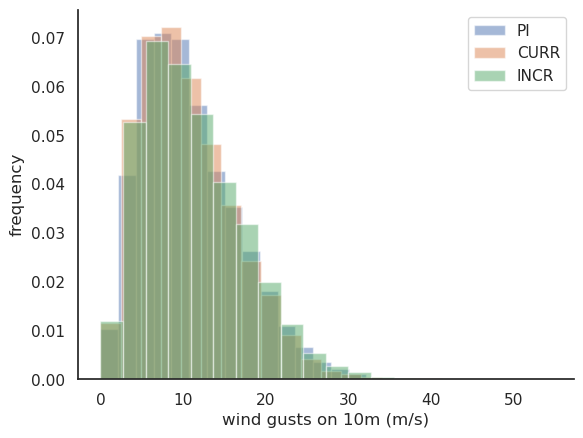

In [32]:
plt.hist(random.sample(wind_gusts_pi, 10000), alpha = 0.5, density = True, bins = 20, label = 'PI')
plt.hist(random.sample(wind_gusts_curr, 10000), alpha = 0.5, density = True, bins = 20, label = 'CURR')
plt.hist(random.sample(wind_gusts_incr, 10000), alpha = 0.5, density = True, bins = 20, label = 'INCR')
plt.xlabel('wind gusts on 10m (m/s)')
plt.ylabel('frequency')
plt.legend()
sns.despine()

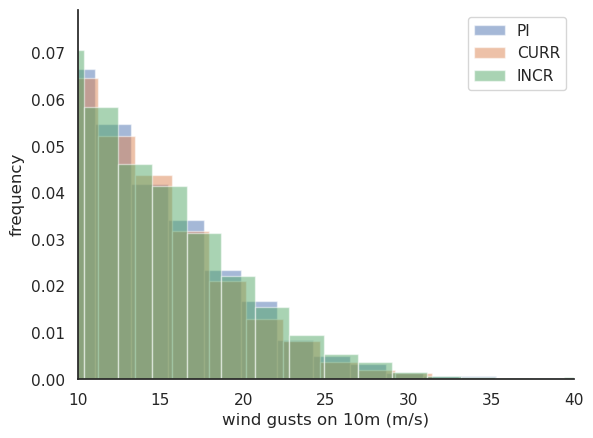

In [9]:
plt.hist(random.sample(wind_gusts_pi, 10000), alpha = 0.5, density = True, bins = 20, label = 'PI')
plt.hist(random.sample(wind_gusts_curr, 10000), alpha = 0.5, density = True, bins = 20, label = 'CURR')
plt.hist(random.sample(wind_gusts_incr, 10000), alpha = 0.5, density = True, bins = 20, label = 'INCR')
plt.xlabel('wind gusts on 10m (m/s)')
plt.ylabel('frequency')
plt.legend()
sns.despine()
plt.xlim((10,40,))

#plt.savefig('figures/01_wind_gusts_hist_zoom.pdf')
#plt.savefig('figures/01_wind_gusts_hist_zoom.png')

## Cumulative wind gusts

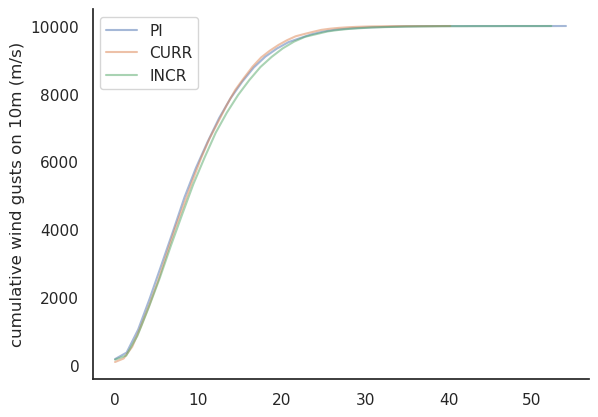

In [36]:
# Calculating cumsums following https://stackoverflow.com/questions/15408371/cumulative-distribution-plots-python

values_pi, base_pi = np.histogram(random.sample(wind_gusts_pi, 10000), bins = 40)
values_curr, base_curr = np.histogram(random.sample(wind_gusts_curr, 10000), bins = 40)
values_incr, base_incr = np.histogram(random.sample(wind_gusts_incr, 10000), bins = 40)

cumsum_pi = np.cumsum(values_pi)
cumsum_curr = np.cumsum(values_curr)
cumsum_incr = np.cumsum(values_incr)

plt.plot(base_pi[:-1], cumsum_pi , alpha = 0.5, label = 'PI')
plt.plot(base_curr[:-1], cumsum_curr, alpha = 0.5, label = 'CURR')
plt.plot(base_incr[:-1], cumsum_incr, alpha = 0.5, label = 'INCR')

plt.ylabel('cumulative wind gusts on 10m (m/s)')
plt.legend()
sns.despine()

## Check statistical significance

### T tests - not significant

In [10]:
print(stats.shapiro(random.sample(wind_gusts_pi, 1000)))  # Normality
print(stats.shapiro(random.sample(wind_gusts_curr, 1000)))
print(stats.levene(random.sample(wind_gusts_pi, 1000), random.sample(wind_gusts_curr, 1000)))  # Homogeneity of variance
print(stats.ttest_ind(random.sample(wind_gusts_pi, 1000), random.sample(wind_gusts_curr, 1000)))

ShapiroResult(statistic=0.9591652154922485, pvalue=4.316703568845549e-16)
ShapiroResult(statistic=0.9596402049064636, pvalue=5.466729465755573e-16)
LeveneResult(statistic=7.456638187164358, pvalue=0.006375811560083073)
Ttest_indResult(statistic=1.9674943009164159, pvalue=0.04926439301358155)


In [11]:
print(stats.shapiro(random.sample(wind_gusts_curr, 1000)))  # Normality
print(stats.shapiro(random.sample(wind_gusts_incr, 1000)))
print(stats.levene(random.sample(wind_gusts_curr, 1000), random.sample(wind_gusts_incr, 1000)))  # Homogeneity of variance
print(stats.ttest_ind(random.sample(wind_gusts_curr, 1000), random.sample(wind_gusts_incr, 1000)))

ShapiroResult(statistic=0.9518397450447083, pvalue=1.4137117201655956e-17)
ShapiroResult(statistic=0.9523054957389832, pvalue=1.7369770468376466e-17)
LeveneResult(statistic=1.5639814353119372, pvalue=0.21122964680660902)
Ttest_indResult(statistic=-6.023909292920391, pvalue=2.021442781597705e-09)


T tests are not applicable here as the data does not follow a normal distribution (see results of Shapiro Wilk test) but even if we apply it, the means would not show a statistical significance.

### Weibull distribution fitting

In [12]:
# Fit weibull distribution
fit_pi= sc.stats.weibull_min.fit(random.sample(wind_gusts_pi, 10000))
fit_curr= sc.stats.weibull_min.fit(random.sample(wind_gusts_curr, 10000))
fit_incr= sc.stats.weibull_min.fit(random.sample(wind_gusts_incr, 10000))
print(fit_pi)
print(fit_curr)
print(fit_incr)

(0.6192559071684951, -1.3307117027677237e-27, 3.0205784409874283)
(0.5694713853642136, -1.9073489310596867e-06, 2.92814467052603)
(0.6843578050508297, -7.245771829249271e-26, 3.629228074086039)


# Compare wind gusts on Friday in South of UK

In [2]:
wind_gusts_pi = []
wind_gusts_incr = []

# Load data from MED-R Preindustrial and increased, as before
directory_exp = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/'

experiments = ['incr', 'pi']
cfpf = ['cf', 'pf']  # control and perturbed are treated equally
inits = {'pi' : ['b2nq_2022-02-10', 'b2nn_2022-02-14', 'b2ns_2022-02-16'], 
           'incr' : ['b2nr_2022-02-10', 'b2no_2022-02-14', 'b2nt_2022-02-16']}  # members for incr and pi runs

for experiment in experiments:
    for init in inits[experiment]:
        for cont in cfpf:
            if experiment == 'pi':
                wind_gusts_pi.append(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).fg10.values)        
            elif experiment == 'incr':
                wind_gusts_incr.append(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).fg10.values)


In [3]:
# Import lat, lon values
lat = xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).latitude.values
lon = xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).longitude.values
 
# Import time steps, NB there are three sets of time steps depending on the initialisation date
fridays = []
for init in inits['pi']:  # time stamps are the same across experiments pi and icnr
    time = xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).time.values
    fridays.append((time > pd.Timestamp(2022,2,18, 0)) & (time < pd.Timestamp(2022,2,18, 18)))

# Defining box to analyse winds, south england and wales
lat1 = 52.2
lat2 = 50.3
lon1 = -6
lon2 = 1.3

# Create mask
south_england = {'lat': (lat < lat1) & (lat > lat2), 'lon': (lon < lon2) & (lon > lon1)}
friday = (time > pd.Timestamp(2022,2,18, 0)) & (time < pd.Timestamp(2022,2,18, 18))

In [5]:
wind_gusts_incr_south = []
wind_gusts_pi_south = []
init_step = 0  # used to loop through fridays i.e. time step mask which varies depending on init date
for i in range(len(wind_gusts_incr)): # going through the combinations of cf/pf and inits
    if i in [0,2,4]:
        masks = np.meshgrid(fridays[init_step], south_england['lat'], south_england['lon'], indexing = 'ij')
        full_mask = np.ma.make_mask(masks[0]*masks[1]*masks[2])
        wind_gusts_incr_south.append(wind_gusts_incr[i][full_mask].reshape(5,7,29)) 
        wind_gusts_pi_south.append(wind_gusts_pi[i][full_mask].reshape(5,7,29))
    elif i in  [1,3,5]:
        masks = np.meshgrid(fridays[init_step], np.ones(50), south_england['lat'], south_england['lon'], indexing = 'ij')
        full_mask = np.ma.make_mask(masks[0]*masks[1]*masks[2]*masks[3])
        pi = wind_gusts_pi[i][full_mask].reshape(5,50,7,29)
        incr = wind_gusts_incr[i][full_mask].reshape(5,50,7,29)
        for member in range(50): # add members individually but they are equal to the control runs
            wind_gusts_pi_south.append(pi[:,member,:,:])
            wind_gusts_incr_south.append(incr[:,member,:,:])
        init_step += 1

wind_gusts_incr_south = np.stack(wind_gusts_incr_south)
wind_gusts_pi_south = np.stack(wind_gusts_pi_south)

        

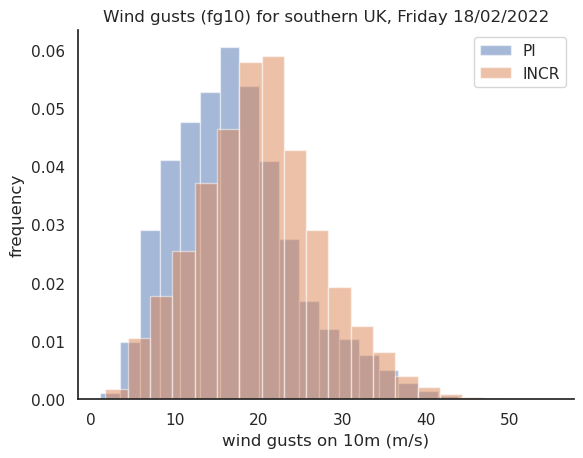

In [6]:
# Plot histograms comparing pi and incr

plt.hist(wind_gusts_pi_south.flatten(), alpha = 0.5, density = True, bins = 20, label = 'PI')
plt.hist(wind_gusts_incr_south.flatten(),  alpha = 0.5, density = True, bins = 20, label = 'INCR')
plt.xlabel('wind gusts on 10m (m/s)')
plt.ylabel('frequency')
plt.legend()
plt.title('Wind gusts (fg10) for southern UK, Friday 18/02/2022')
sns.despine()

plt.savefig('figures/01_wind_gusts_hist.pdf')
plt.savefig('figures/01_wind_gusts_hist.png')